In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# to print all output for a cell instead of only last one
import sys

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
sys.path.insert(0, "..")

In [3]:
import os
from string import punctuation

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
from nltk.corpus import stopwords
from pandas.core.common import flatten
from sklearn.ensemble import RandomForestClassifier

In [5]:
import json
from pathlib import Path

import pandas as pd

def loadData():
    json_file_path_train = '/content/drive/MyDrive/Major Project/Different combinations/data/Twibot-20/train.json'
    json_file_path_val = '/content/drive/MyDrive/Major Project/Different combinations/data/Twibot-20/dev.json'
    json_file_path_test = '/content/drive/MyDrive/Major Project/Different combinations/data/Twibot-20/test.json'
    with open(json_file_path_train, 'r') as tr:
        contents = json.loads(tr.read())
        train_df = pd.json_normalize(contents)
        train_df['split'] = 'train'

    with open(json_file_path_val, 'r') as vl:
        contents = json.loads(vl.read())
        val_df = pd.json_normalize(contents)
        val_df['split'] = 'val'

    with open(json_file_path_test, 'r') as ts:
        contents = json.loads(ts.read())
        test_df = pd.json_normalize(contents)
        test_df['split'] = 'test'

    df = pd.concat([train_df,val_df,test_df],ignore_index=True) # merge three datasets
    df.dropna(subset=['tweet'], inplace=True)  # remove rows withot any tweet
    df.set_index(keys='ID',inplace=True) # reset index

    # split dataframe in two : tweet and account data
    tweets_df = df[['tweet','label','split']].reset_index()
    tweets_df = tweets_df.explode('tweet').reset_index(drop=True)
    tweets_df.rename(columns={"ID": "account_id"}, inplace=True)

    account_df = df.drop('tweet',axis=1).reset_index()
    account_df.rename(columns={"ID": "account_id"}, inplace=True)

    return tweets_df, account_df

In [6]:
tweets_df, account_df = loadData()
print(tweets_df.loc[9,'tweet'])

We did it! The first ever #SHAQvsGRONK had over 9 MILLION live viewers who helped @GRONK and I raise money for the @NAACP and @BGCCAN with 1.25 million meals donated to @FeedingAmerica. A big shoutout to @TheGeneralAuto and everyone who performed. Watch this  👀 (🎥: @lanreako) https://t.co/sf7EVKjROT



In [ ]:
# from nltk.tokenize import TweetTokenizer
# import re
# import pandas as pd

# def preprocess_tweet(tweet):
#     tk = TweetTokenizer(reduce_len=True, preserve_case=False)

#     # Define the replacements
#     replacements = {
#         r"RT @[\w_]+": " retweet ",
#         r"\$[\w_]+": " stock ",
#         r"[\w\.-]+@[\w\.-]+": " email ",
#         r"\d+": " number ",
#         r"[$£]\d+|[0-9]+[$£]": " money ",
#         r"#\w+": " hashtag ",
#         r"@\w+": " username ",
#         r"http\S+|www\.\S+": " url ",
#         r"(?:\bha+ha+\b|\bja+ja+\b)": " ahah ",
#         r"😀+": " emoji ",
#         r"[:<][)3]": " emoticon "
#     }

#     # Apply the replacements
#     for pattern, replacement in replacements.items():
#         tweet = re.sub(pattern, replacement, tweet)

#     # Tokenize the tweet
#     tokens = tk.tokenize(tweet)

#     # Remove extra spaces and non-ascii words
#     tokens = [token for token in tokens if token.strip() and token.isascii()]

#     return tokens

In [ ]:
# tweets_df['processed_tweet'] = tweets_df['tweet'].apply(preprocess_tweet)

In [ ]:
# tweets_df.to_pickle('/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v1.pkl')

In [7]:
import  pandas as pd
cleaned_df = pd.read_pickle('/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v1.pkl')
print(cleaned_df.loc[9,'processed_tweet'])

['we', 'did', 'it', '!', 'the', 'first', 'ever', 'hashtag', 'had', 'over', 'number', 'million', 'live', 'viewers', 'who', 'helped', 'username', 'and', 'i', 'raise', 'money', 'for', 'the', 'username', 'and', 'username', 'with', 'number', '.', 'number', 'million', 'meals', 'donated', 'to', 'username', '.', 'a', 'big', 'shoutout', 'to', 'username', 'and', 'everyone', 'who', 'performed', '.', 'watch', 'this', '(', ':', 'username', ')', 'url', 'number', 'evkjrot']




## **Single Tweet Text + Custom Tweet Features**


In [ ]:
# import re

# with open(r'/content/drive/MyDrive/Major Project/Different combinations/data/corpora/stopwords/english', 'r') as f:
#     stopwords = f.read().splitlines()

# def extract_features(tweet):
#     features = {}

#     # Check if the tweet is a retweet
#     features['is_rt'] = tweet.startswith('RT')

#     # Count the number of hashtags, tags, URLs, cashtags, currency symbols, emails, numbers, emoticons, emojis, stopwords, punctuation
#     features['hashtag_c'] = tweet.count('#')
#     features['tag_c'] = tweet.count('@')
#     features['url_c'] = len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet))
#     features['cashtag_c'] = tweet.count('$')
#     features['money_c'] = len(re.findall(r'\$|\£|\€', tweet))
#     features['email_c'] = len(re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', tweet))
#     features['number_c'] = len(re.findall(r'\b\d+\b', tweet))
#     features['emoticon_c'] = len(re.findall(r':\)|<3|…', tweet))
#     features['emoji_c'] = len(re.findall(r'😀', tweet))
#     features['stopword_c'] = len([word for word in tweet.split() if word in stopwords])
#     features['punctuation_c'] = len(re.findall(r'[^\w\s]', tweet))

#     # Get the length of the tweet
#     features['len_tweet'] = len(tweet)

#     return features

In [ ]:
# # Apply the function to the 'tweet' column
# tweets_df['features'] = tweets_df['tweet'].apply(extract_features)

# tweets_df.to_pickle('processed_dataset_v2.pkl')

In [ ]:
# # Convert the 'features' column into separate columns
# features_df = pd.json_normalize(tweets_df['features'])

# # Concatenate the original DataFrame with the new DataFrame of features
# tweets_df = pd.concat([tweets_df, features_df], axis=1)

# # Save the DataFrame
# tweets_df.to_pickle('/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v2.pkl')

In [9]:
import pandas as pd

singletweet_features_df = pd.read_pickle('/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v2.pkl')
singletweet_features_df.head(3)

,account_id,tweet,label,split,processed_tweet,features,is_rt,hashtag_c,tag_c,url_c,cashtag_c,money_c,email_c,number_c,emoticon_c,emoji_c,stopword_c,punctuation_c,len_tweet
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,0,train,"[retweet, :, are, you, ready, to, see, what, o...","{'is_rt': True, 'hashtag_c': 0, 'tag_c': 1, 'u...",True,0,1,0,0,0,0,0,1,0,10,8,141
1,17461978,Who has time for receipts? Not me. @epson rece...,0,train,"[who, has, time, for, receipts, ?, not, me, .,...","{'is_rt': False, 'hashtag_c': 0, 'tag_c': 1, '...",False,0,1,2,0,0,0,0,0,0,7,17,159
2,17461978,Steady wants to encourage you to invest in you...,0,train,"[steady, wants, to, encourage, you, to, invest...","{'is_rt': False, 'hashtag_c': 1, 'tag_c': 1, '...",False,1,1,2,1,1,0,2,0,0,15,19,305


In [ ]:
# plt.figure(figsize=(15,8))
# cor = singletweet_features_df.corr(numeric_only=True)
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_classif, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
# feature_columns = ['is_rt','url_c','tag_c','hashtag_c','cashtag_c','money_c','email_c','emoji_c','emoticon_c','len_tweet']
# train_ds = singletweet_features_df[singletweet_features_df['split'] == 'train'].reset_index(drop=True)
# val_ds = singletweet_features_df[singletweet_features_df['split'] == 'val'].reset_index(drop=True)
# test_ds = singletweet_features_df[singletweet_features_df['split'] == 'test'].reset_index(drop=True)

# X_train = train_ds[feature_columns]
# y_train = train_ds['label']

# X_test = val_ds[feature_columns]
# y_test = val_ds['label']

# # feature selection
# X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# # what are scores for the features
# for i in range(len(fs.scores_)):
# 	print(f'{i} -> {feature_columns[i]}: {fs.scores_[i]:.3f}')
# # plot the scores

# plt.figure(figsize=(30,10))
# plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
# plt.show()

In [ ]:
# num_rt_bot = singletweet_features_df[(singletweet_features_df['is_rt'] == 1.0) & (singletweet_features_df['label'] == 1.0)].shape[0]
# num_nort_bot = singletweet_features_df[(singletweet_features_df['is_rt'] == 0.0) & (singletweet_features_df['label'] == 1.0)].shape[0]
# num_tweets = singletweet_features_df.shape[0]
# print(f'Number of tweets from bots which are retweet: {num_rt_bot} - ({num_rt_bot/num_tweets*100:.1f}%)')
# print(f'Number of tweets from bots which are not retweet: {num_nort_bot} - ({num_nort_bot/num_tweets*100:.1f}%)\n')

# num_rt_human = singletweet_features_df[(singletweet_features_df['is_rt'] == 1.0) & (singletweet_features_df['label'] == 0.0)].shape[0]
# num_nort_human = singletweet_features_df[(singletweet_features_df['is_rt'] == 0.0) & (singletweet_features_df['label'] == 0.0)].shape[0]
# print(f'Number of tweets from humans which are retweet: {num_rt_human} - ({num_rt_human/num_tweets*100:.1f}%)')
# print(f'Number of tweets from humans which are not retweet: {num_nort_human} - ({num_nort_human/num_tweets*100:.1f}%)\n')

# print(f"Pearson Correlation:\n{singletweet_features_df[['is_rt','label']].corr()}")

In [ ]:
# print(f"Pearson Correlation:\n{singletweet_features_df[['cashtag_c','label']].corr(numeric_only=True)}")

In [ ]:
# mean_url_bot = singletweet_features_df[singletweet_features_df['label'] == 1.0]['url_c'].mean()
# mean_url_nobot = singletweet_features_df[singletweet_features_df['label'] == 0.0]['url_c'].mean()
# print(f"Average z-score of URLs per single tweet by bot user: {mean_url_bot:.3f}")
# print(f"Average z-score of URLs per single tweet by human user: {mean_url_nobot:.3f}")
# print(f"Difference: {abs(mean_url_bot - mean_url_nobot):.3f}")

In [ ]:
# mean_hashtag_bot = singletweet_features_df[singletweet_features_df['label'] == 1.0]['hashtag_c'].mean()
# mean_hashtag_nobot = singletweet_features_df[singletweet_features_df['label'] == 0.0]['hashtag_c'].mean()
# print(f"Average z-score of hashtags per single tweet by bot user: {mean_hashtag_bot:.3f}")
# print(f"Average z-score of hashtags per single tweet by human user: {mean_hashtag_nobot:.3f}")
# print(f"Difference: {abs(mean_hashtag_bot - mean_hashtag_nobot):.3f}")


##**Multi Tweet level**

In [10]:
def extract_multitweet_features(user_tweets):
    features = {}

    # Calculate features
    features['avg_length'] = np.mean([len(tweet) for tweet in user_tweets])
    features['avg_cleaned_length'] = np.mean([len(re.sub(r'RT|@|#|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|\$|\£|\€|\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b|\b\d+\b|:\)|<3|…|😀', '', tweet)) for tweet in user_tweets])
    features['1+_mention'] = sum(['@' in tweet for tweet in user_tweets])
    features['1+_emot'] = sum([':)' in tweet or '<3' in tweet or '…' in tweet or '😀' in tweet for tweet in user_tweets])
    features['1+_url'] = sum([re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet) is not None for tweet in user_tweets])
    features['max_hashtag'] = max([tweet.count('#') for tweet in user_tweets])
    features['max_mentions'] = max([tweet.count('@') for tweet in user_tweets])
    features['unique_words_ratio'] = np.mean([len(set(tweet.split())) / len(tweet.split()) for tweet in user_tweets if len(tweet.split()) > 0])
    features['url_count'] = sum([tweet.count('http') for tweet in user_tweets])
    features['hashtag_count'] = sum([tweet.count('#') for tweet in user_tweets])
    features['unique_hashtag_ratio'] = np.mean([len(set(re.findall(r'#\w+', tweet))) / tweet.count('#') for tweet in user_tweets if tweet.count('#') > 0])
    features['mention_count'] = sum([tweet.count('@') for tweet in user_tweets])
    features['unique_mention_ratio'] = np.mean([len(set(re.findall(r'@\w+', tweet))) / tweet.count('@') for tweet in user_tweets if tweet.count('@') > 0])
    features['emot_count'] = sum([':)' in tweet or '<3' in tweet or '…' in tweet or '😀' in tweet for tweet in user_tweets])
    features['punct_count'] = sum([len(re.findall(r'[^\w\s]', tweet)) for tweet in user_tweets])
    features['?!_count'] = sum([tweet.count('?') + tweet.count('!') for tweet in user_tweets])
    features['uppercased_count'] = sum([len(re.findall(r'[A-Z]', tweet)) for tweet in user_tweets])
    features['cash_money_count'] = sum([tweet.count('stock') + tweet.count('money') for tweet in user_tweets])
    features['rt_count'] = sum([tweet.startswith('RT') for tweet in user_tweets])
    features['unique_rt_ratio'] = len(set([tweet for tweet in user_tweets if tweet.startswith('RT')])) / features['rt_count'] if features['rt_count'] > 0 else 0

    return features

In [ ]:
# tweets_df['features'] = extract_multitweet_features(tweets_df['tweet'])

# # Convert the 'features' column into separate columns
# features_df = tweets_df['features'].apply(pd.Series)

# # Concatenate the original DataFrame with the new DataFrame of features
# tweets_df = pd.concat([tweets_df, features_df], axis=1)

# # Save the DataFrame
# tweets_df.to_pickle('processed_dataset_v3.pkl')

In [12]:
multitweet_features_df = pd.read_pickle('/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v3.pkl')
multitweet_features_df_train = multitweet_features_df[multitweet_features_df['split'] == 'train']
multitweet_features_df_train.head(3)

,account_id,tweet,label,split,features,avg_length,avg_cleaned_length,1+_mention,1+_emot,1+_url,...,unique_hashtag_ratio,mention_count,unique_mention_ratio,emot_count,punct_count,?!_count,uppercased_count,cash_money_count,rt_count,unique_rt_ratio
0,17461978,RT @CarnivalCruise: 🎉 Are you ready to see wha...,0,train,"{'avg_length': 1.0, 'avg_cleaned_length': 0.98...",1.0,0.985816,1.0,1.0,0.0,...,NaN,1.0,0.0,1.0,8.0,1.0,6.0,0.0,0.0,0.0
1,17461978,Who has time for receipts? Not me. @epson rece...,0,train,"{'avg_length': 1.0, 'avg_cleaned_length': 0.97...",1.0,0.974843,1.0,0.0,0.0,...,NaN,1.0,0.0,0.0,17.0,2.0,9.0,0.0,0.0,0.0
2,17461978,Steady wants to encourage you to invest in you...,0,train,"{'avg_length': 1.0, 'avg_cleaned_length': 0.96...",1.0,0.960656,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,19.0,1.0,16.0,0.0,0.0,0.0


In [13]:
multitweet_features_df_train.loc[:, '1+_url'] = multitweet_features_df_train['1+_url'].astype(int)

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='label', ylabel='count'>

Text(0.5, 1.0, 'Count of Tweets with and without URLs for Each Label Category')

Text(0.5, 0, 'Label Category')

Text(0, 0.5, 'Count')

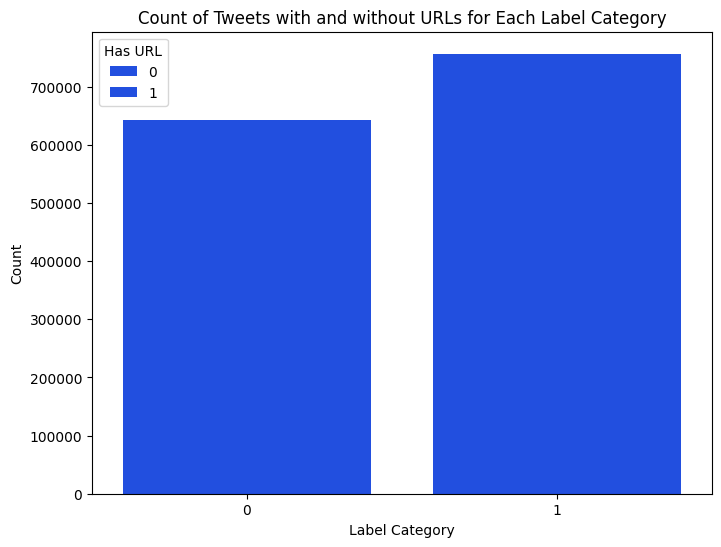

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define colors for '1+_url' categories
sns.set_palette("bright")

# Plot count of tweets with and without URLs for each label category
plt.figure(figsize=(8, 6))
sns.countplot(data=multitweet_features_df_train, x='label', hue='1+_url')
plt.title('Count of Tweets with and without URLs for Each Label Category')
plt.xlabel('Label Category')
plt.ylabel('Count')
plt.legend(title='Has URL', labels=['0', '1'])
plt.show()


##**Account level**


In [15]:
!pip install emoji Levenshtein emot ttp wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00


In [16]:
import collections
import math
import os
import re
from datetime import datetime
from statistics import mean
from string import punctuation
import emoji
import Levenshtein
import nltk
import pandas as pd
from emot.core import emot
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from pandas.core.common import flatten
from sklearn.preprocessing import StandardScaler
from ttp import ttp


In [17]:
def process_account_dataset(dataframe : pd.DataFrame, normalize : bool) :

    to_drop = ['neighbor','domain','profile.id','profile.id_str','profile.profile_location','profile.entities','profile.utc_offset','profile.time_zone','profile.lang',
'profile.contributors_enabled','profile.is_translator','profile.is_translation_enabled','profile.profile_background_color','profile.profile_background_image_url','profile.profile_background_image_url_https',
'profile.profile_background_tile','profile.profile_image_url','profile.profile_image_url_https','profile.profile_link_color','profile.profile_sidebar_border_color','profile.profile_sidebar_fill_color',
'profile.profile_text_color','profile.has_extended_profile','neighbor.following', 'neighbor.follower']

    rename_dict = {'profile.name': 'name', 'profile.screen_name': 'screen_name', 'profile.location': 'location','profile.description':'description',
'profile.url' : 'url', 'profile.protected' : 'protected', 'profile.followers_count':'followers_count', 'profile.friends_count':'friends_count',
'profile.listed_count':'listed_count','profile.created_at' :'created_at', 'profile.favourites_count' :'favourites_count','profile.geo_enabled':'geo_enabled',
'profile.verified':'verified', 'profile.statuses_count':'statuses_count','profile.profile_use_background_image' : 'background_image',
'profile.default_profile' : 'default_profile', 'profile.default_profile_image':'default_profile_image'}


    to_ignore = ['is_verified','has_desc','bot_word_in_name','bot_word_in_screen_name','bot_word_in_description','num_in_name','urls_in_description','def_image','is_protected','use_background_img']


    def description_len(desc:str):
        if desc == "":
            return 0
        else :
            return len(desc)

    def fofo_ratio(f1: str ,f2: str):
        f1,f2 = int(f1), int(f2)
        if f2 == 0.0 :
            return f1
        else :
            return f1/f2

    def numbers_in_str(s : str):
        return len(re.findall(r'\d+', s))

    def hashtag_in_str(s: str):
        return len(re.findall(r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""",s))

    def urls_in_str(s: str):
        urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', s)
        return len(urls)

    def bot_world_in_str(s: str):
        return int(bool(re.search('bot', s, flags=re.IGNORECASE)))

    def get_str_entropy(s : str):
        counter = collections.Counter(s)
        screen_name_entropy = 0
        for key, cnt in counter.items():
            prob = float(cnt) / len(s)
            screen_name_entropy += -1 * prob * math.log(prob, 2)
        return screen_name_entropy

    def get_account_age(created_at : str) :
        Twibot_20_FORMAT = f'%a %b %d %H:%M:%S %z %Y'
        creation_date = datetime.strptime(created_at,Twibot_20_FORMAT).date()
        present_date = datetime.now().date()
        user_age = (present_date - creation_date).days
        return int(user_age)

    def frequency(created_at : str, numerator : str):
        age = get_account_age(created_at)
        avg_tweets = int(numerator) / age
        return avg_tweets

    def lev_name_screenName(name : str, screen_name : str) :
        return Levenshtein.distance(name,screen_name)


    df = dataframe.copy(deep=True)

    df = df.drop(to_drop,axis=1).reset_index(drop=True)  # drop unuseful columns
    df.rename(columns=rename_dict, inplace=True)         # rename all columns
    df = df.applymap(lambda x : x.rstrip() if isinstance(x, str) else x)              # strip the trailing space added by twitter


    feature_df = df[['account_id','label','split']].reset_index(drop=True)
    feature_df['label'] = feature_df['label'].astype(float)


    #KOUVELA
    feature_df['has_desc'] = (df['description'] != '').astype(int)  #check lenght 1486
    feature_df['has_location'] = (df['location'] != '').astype(int)  #check lenght 3386
    feature_df['has_url'] = (df['url'] != 'None').astype(int)  #check lenght 5965
    feature_df['is_verified'] = (df['verified'] == 'True').astype(int)  #check lenght 2962
    feature_df['bot_word_in_name'] = df['name'].apply(bot_world_in_str)
    feature_df['bot_word_in_screen_name'] = df['screen_name'].apply(bot_world_in_str)
    feature_df['bot_word_in_description'] = df['description'].apply(bot_world_in_str)
    feature_df['name_len'] = df['name'].apply(len)
    feature_df['screen_name_len'] = df['screen_name'].apply(len)
    feature_df['description_len'] = df['description'].apply(description_len)
    feature_df['followings_count'] = df['friends_count'].astype(int)
    feature_df['followers_count'] = df['followers_count'].astype(int)
    feature_df['fofo_ratio'] = df.apply(lambda x: fofo_ratio(x['followers_count'], x['friends_count']), axis=1)
    feature_df["tweets_count"] = df['statuses_count'].astype(int)
    feature_df["listed_count"] = df['listed_count'].astype(int)
    feature_df["num_in_name"] = df['name'].apply(numbers_in_str)
    feature_df["num_in_screen_name"] = df['screen_name'].apply(numbers_in_str)
    feature_df['hashtag_in_description'] = df['description'].apply(hashtag_in_str)
    feature_df['urls_in_description'] = df['description'].apply(urls_in_str)
    feature_df['def_image'] = (df['default_profile_image'] == 'True').astype(int)
    feature_df['def_profile'] = (df['default_profile'] == 'True').astype(int)

    #KANTEPE
    feature_df['is_protected'] = (df['protected'] == 'True').astype(int)
    feature_df['screen_name_entropy'] = df['screen_name'].apply(get_str_entropy)
    feature_df['tweet_freq'] = df.apply(lambda x: frequency(x['created_at'], x['statuses_count']), axis=1)

    #KNAUTH
    feature_df['is_geo_enabled'] = (df['geo_enabled'] == 'True').astype(int)
    feature_df["favourites_count"] = df['favourites_count'].astype(int)
    feature_df['use_background_img'] = (df['background_image'] == 'True').astype(int)
    feature_df['lev_dist_name_screeName'] = df.apply(lambda x: lev_name_screenName(x['name'], x['screen_name']), axis=1)

    #SGBOT
    feature_df['followers_growth_rate'] = df.apply(lambda x: frequency(x['created_at'], x['followers_count']), axis=1)
    feature_df['followings_growth_rate'] = df.apply(lambda x: frequency(x['created_at'], x['friends_count']), axis=1)
    feature_df['favourites_growth_rate'] = df.apply(lambda x: frequency(x['created_at'], x['favourites_count']), axis=1)

    feature_df = feature_df.drop(to_ignore,axis=1).reset_index(drop=True)

    if normalize :
        columns_names = feature_df.columns.difference(['account_id','label','split'])
        #feature_df[columns_names] = feature_df[columns_names].apply(zscore)
        train_df = feature_df[feature_df['split'] =='train']
        scaler = StandardScaler()
        scaler.fit(train_df[columns_names])

        feature_df[columns_names] = scaler.transform(feature_df[columns_names])


    return feature_df

In [18]:
# account_df = process_account_dataset(account_df,False)
account_df=pd.read_pickle("/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v4.pkl")

In [20]:
# account_df = process_account_dataset(account_df,False)
account_df_train = account_df[account_df['split'] == 'train']

median_fofo_bot = account_df_train[account_df_train['label'] == 1.0]['fofo_ratio'].median()
median_fofo_nobot = account_df_train[account_df_train['label'] == 0.0]['fofo_ratio'].median()
median_fofo = account_df_train['fofo_ratio'].median()
print(f"Median followers/following ratio per account: {median_fofo:.3f}")
print(f"Median followers/following ratio per bot account: {median_fofo_bot:.3f} ({(median_fofo_bot-median_fofo)/median_fofo*100:.3f}%)")
print(f"Median followers/following ratio per human account: {median_fofo_nobot:.3f} (+{(median_fofo_nobot-median_fofo)/median_fofo*100:.3f}%)")

Median followers/following ratio per account: -0.033
Median followers/following ratio per bot account: -0.033 (0.001%)
Median followers/following ratio per human account: -0.033 (+-0.083%)


In [ ]:
account_df.head()

,account_id,label,split,has_location,has_url,name_len,screen_name_len,description_len,followings_count,followers_count,...,hashtag_in_description,def_profile,screen_name_entropy,tweet_freq,is_geo_enabled,favourites_count,lev_dist_name_screeName,followers_growth_rate,followings_growth_rate,favourites_growth_rate
0,17461978,0.0,train,1,1,4,4,50,692,15349596,...,0,0,2.000000,1.739702,1,142,0,2725.425426,0.122869,0.025213
1,17685258,0.0,train,1,1,13,8,160,475,762839,...,0,0,2.750000,0.981327,1,953,6,135.664058,0.084474,0.169482
2,15750898,0.0,train,1,1,16,9,160,4801,327587,...,0,0,3.169925,33.625523,1,2946,11,57.110704,0.836994,0.513598
3,1659167666,1.0,train,1,1,17,14,103,647,13324,...,0,1,3.664498,0.026370,0,729,5,3.411162,0.165643,0.186636
4,34743251,0.0,train,1,1,6,6,90,96,12601567,...,0,0,2.584963,0.890979,0,177,0,2301.235756,0.017531,0.032323


In [21]:
print(f'Followers/following ratio of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'fofo_ratio']]
print(f'Followers/following ratio of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'fofo_ratio']]

Followers/following ratio of 5 random bot accounts:


,account_id,fofo_ratio
7031,125621689,-0.033108
3580,3158412026,-0.033109
3185,347275112,-0.033109
6196,999128303179976704,-0.033109
5511,1428675840,-0.033106


Followers/following ratio of 5 random human accounts:


,account_id,fofo_ratio
3566,933024055514583040,-0.033106
324,68034431,0.093891
3153,116791717,-0.033108
3549,1266461003056889858,-0.033108
2942,2171242562,-0.033109


In [ ]:
print(f'Default profile feature of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'def_profile']]
print(f'Default profile feature of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'def_profile']]

Default profile feature of 5 random bot accounts:


,account_id,def_profile
4173,435820478,0
2214,53260985,0
7882,1211015109432102913,1
6672,449514961,1
4502,828302764371542016,0


Default profile feature of 5 random human accounts:


,account_id,def_profile
2557,816649003,1
1599,468782607,0
906,1162632572918292481,1
8102,836968183680614400,0
1473,36617822,0


In [ ]:
print(f'Numbers in screen name of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'num_in_screen_name']]
print(f'Numbers in screen name of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'num_in_screen_name']]

Numbers in screen name of 5 random bot accounts:


,account_id,num_in_screen_name
7492,194092306,0
3716,751552860303683584,0
5311,168788869,0
875,1150447252537794560,1
7138,28884655,0


Numbers in screen name of 5 random human accounts:


,account_id,num_in_screen_name
3111,912265488,0
141,3420965229,0
2053,1202644437454794754,1
667,425871040,0
1785,124450567,0


In [ ]:
print(f'Location enabled of 5 random bot accounts:')
account_df_train[account_df_train['label'] == 1.0].sample(n=5)[['account_id', 'has_location']]
print(f'Location enabled of 5 random human accounts:')
account_df_train[account_df_train['label'] == 0.0].sample(n=5)[['account_id', 'has_location']]

Location enabled of 5 random bot accounts:


,account_id,has_location
3232,1291016101850218497,0
4392,822885298682011648,1
6947,1199008490540412942,0
6601,992020724939358208,1
3411,762082430966784000,1


Location enabled of 5 random human accounts:


,account_id,has_location
5520,419920053,1
190,456095936,1
1344,67611162,1
961,70663487,1
5585,2633624624,0


## **Random Forest**



In [ ]:
 account_df=pd.read_pickle('/content/drive/MyDrive/Major Project/Different combinations/data/processed_dataset_v4.pkl')

In [ ]:
NUM_ESTIMATORS = 100
CLASS_WEIGHT = 'balanced'
RND_STATE = 18

train = account_df[account_df['split'] == 'train'].reset_index(drop=True)
val = account_df[account_df['split'] == 'val'].reset_index(drop=True)
test = account_df[account_df['split'] == 'test'].reset_index(drop=True)

X_train, y_train = train.drop(columns=["account_id", "label", "split"], axis=1), train["label"]
X_val, y_val = val.drop(columns=["account_id", "label", "split"], axis=1), val["label"]
X_test, y_test = test.drop(columns=["account_id", "label", "split"], axis=1), test["label"]

rf = RandomForestClassifier(n_estimators=NUM_ESTIMATORS, class_weight=CLASS_WEIGHT, random_state=RND_STATE)
rf.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plt.barh(train.drop(columns=["account_id", "label", "split"], axis=1).columns, rf.feature_importances_)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score

In [ ]:
y_test_pred = rf.predict(X_test)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1-score:", test_f1)

Accuracy: 0.7681159420289855
Precision: 0.7326478149100257
Recall: 0.8990536277602523
F1-score: 0.8073654390934845
